In [ ]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 21.0 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

from google.colab import files


In [2]:
# Upload file dari lokal
uploaded = files.upload()

Saving used_car.csv to used_car.csv


In [3]:
# 1. MEMUAT DATASET
df = pd.read_csv("used_car.csv")
print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (609, 20)
                car name     brand  year  mileage (km)           location  \
0             AYLA X 1.2  Daihatsu  2018        10.508      Jakarta Utara   
1  AGYA TRD SPORTIVO 1.0    Toyota  2015       112.888              Bogor   
2            X-TRAIL 2.5    Nissan  2015       118.429           Surabaya   
3        YARIS S TRD 1.5    Toyota  2020        15.945  Tangerang Selatan   
4             AGYA G 1.2    Toyota  2019        30.404      Jakarta Barat   

  transmission  plate type  rear camera  sun roof  auto retract mirror  \
0       Manual  even plate            0         0                    0   
1       Manual  even plate            0         0                    0   
2    Automatic   odd plate            0         0                    0   
3    Automatic   odd plate            0         0                    0   
4       Manual   odd plate            0         0                    0   

   electric parking brake  map navigator  vehicle stability control

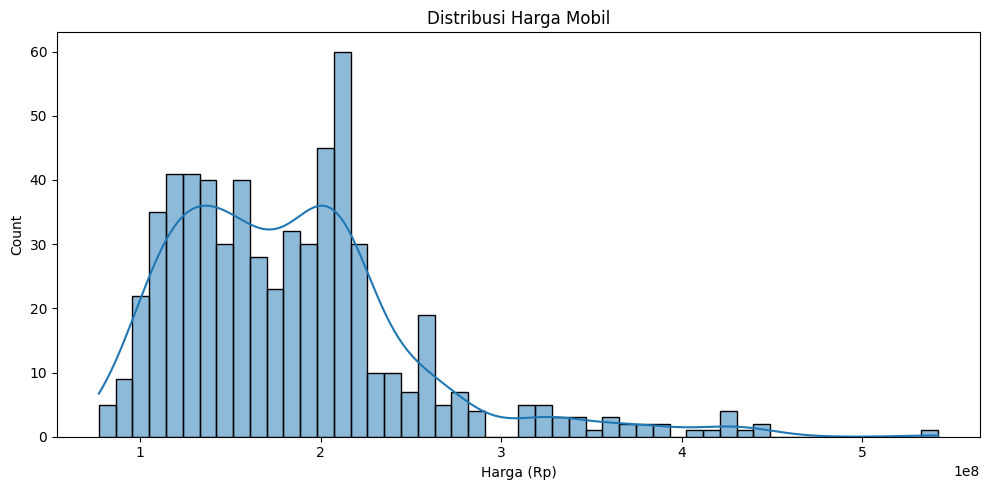

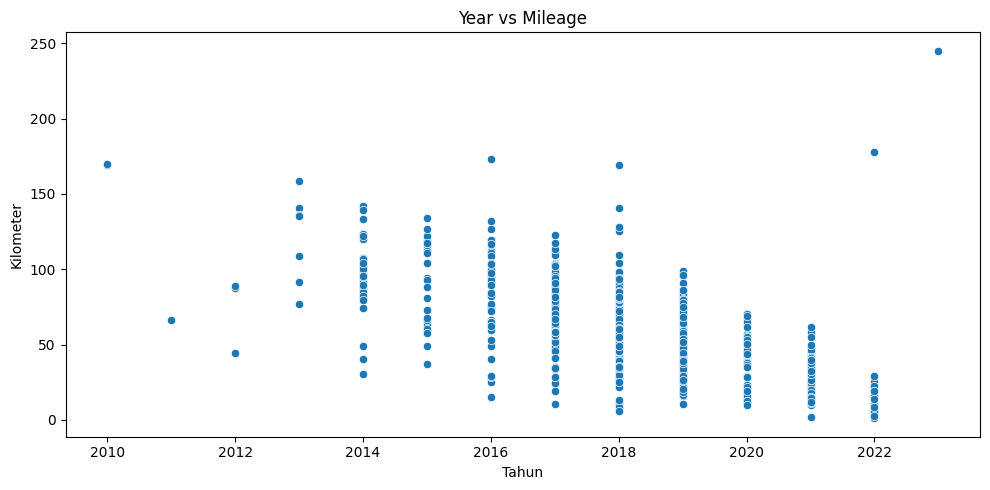

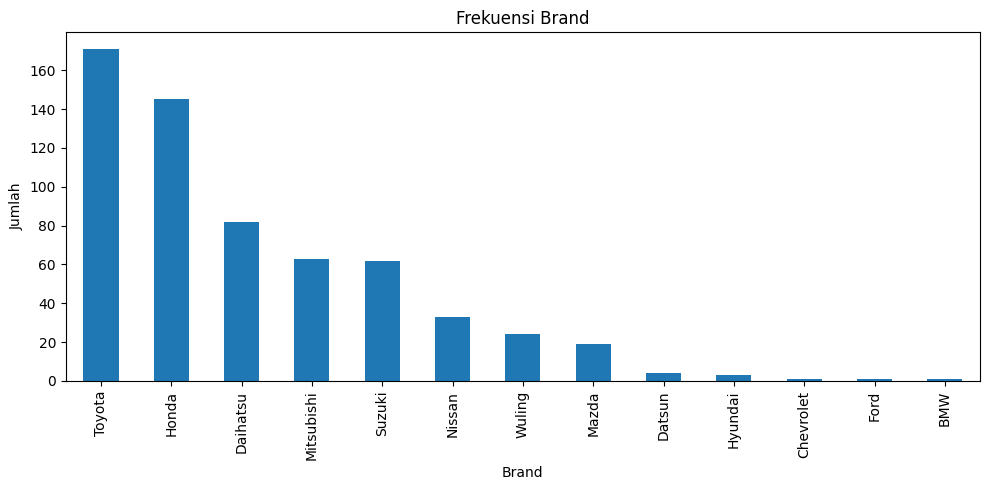

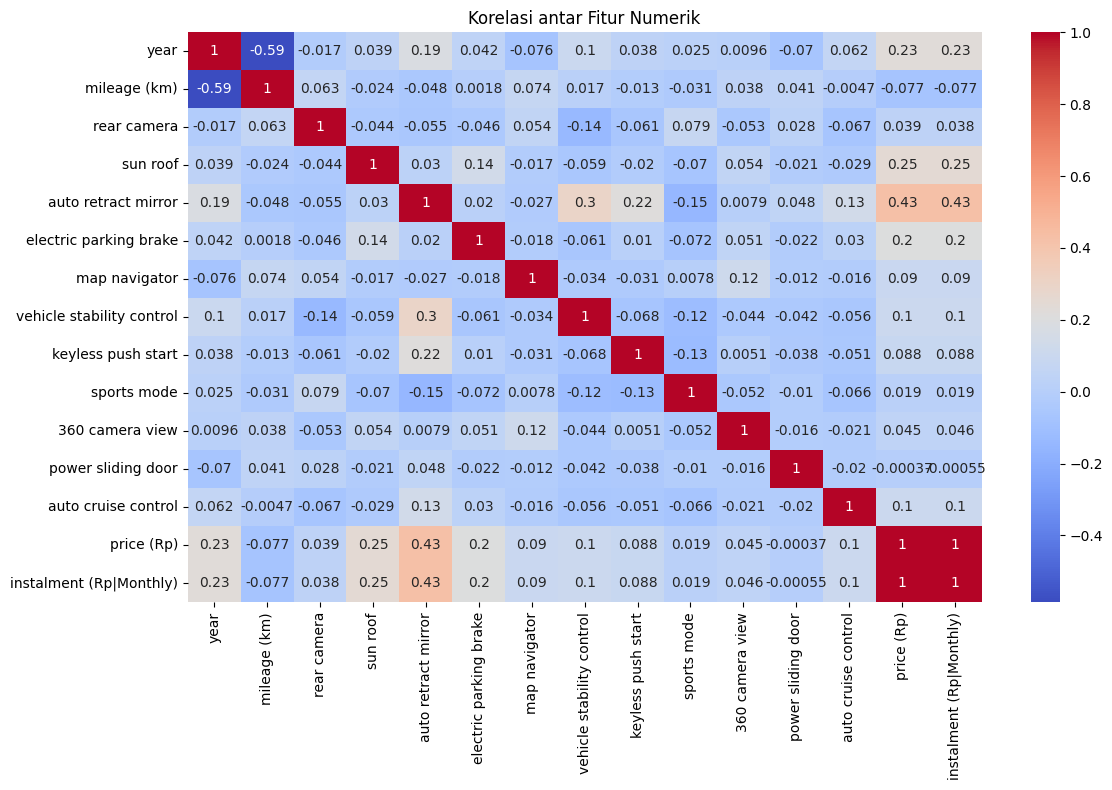

In [4]:
# 2. EDA
plt.figure(figsize=(10, 5))
sns.histplot(df['price (Rp)'], bins=50, kde=True)
plt.title("Distribusi Harga Mobil")
plt.xlabel("Harga (Rp)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['year'], y=df['mileage (km)'])
plt.title("Year vs Mileage")
plt.xlabel("Tahun")
plt.ylabel("Kilometer")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
df['brand'].value_counts().plot(kind='bar')
plt.title("Frekuensi Brand")
plt.xlabel("Brand")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Korelasi antar Fitur Numerik")
plt.tight_layout()
plt.show()


In [5]:
# 3. PREPROCESSING
# Isi missing values
df['location'].fillna('Unknown', inplace=True)
binary_cols = ['rear camera', 'sun roof', 'auto retract mirror', 'electric parking brake',
               'map navigator', 'vehicle stability control', 'keyless push start',
               'sports mode', '360 camera view', 'power sliding door', 'auto cruise control']
df[binary_cols] = df[binary_cols].fillna(0)

# Encode kategori
cat_cols = ['transmission', 'plate type', 'location', 'brand']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Simpan target asli (harga dalam Rp)
y = df['price (Rp)']

# Scale fitur numerik (kecuali target)
scaler = StandardScaler()
num_cols = ['year', 'mileage (km)', 'instalment (Rp|Monthly)']
df[num_cols] = scaler.fit_transform(df[num_cols])

# Drop kolom yang tidak digunakan
X = df.drop(columns=['price (Rp)', 'car name'], errors='ignore')

# Simpan dataset preprocessed
df.to_csv("used_car_preprocessed.csv", index=False)
print("Dataset preprocessed disimpan ke used_car_preprocessed.csv")

# 4. SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. MODELING
# XGBoost
xgb_model = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


Dataset preprocessed disimpan ke used_car_preprocessed.csv



HASIL EVALUASI MODEL
XGBoost -> MAE: Rp 378,236 | RMSE: Rp 1,341,885 | R²: 0.9996
Random Forest -> MAE: Rp 865,317 | RMSE: Rp 3,329,705 | R²: 0.9978


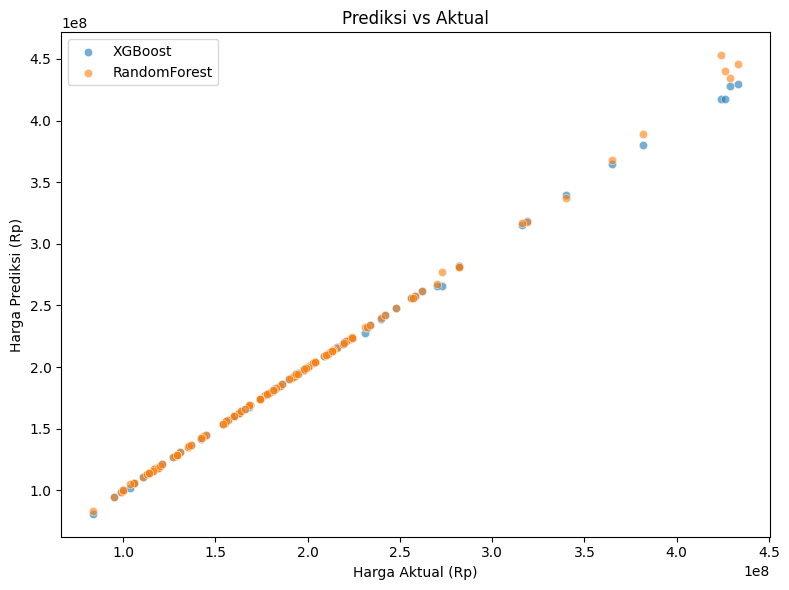

In [6]:
# 6. EVALUASI
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> MAE: Rp {mae:,.0f} | RMSE: Rp {rmse:,.0f} | R²: {r2:.4f}")

print("\nHASIL EVALUASI MODEL")
evaluate_model("XGBoost", y_test, y_pred_xgb)
evaluate_model("Random Forest", y_test, y_pred_rf)

# 7. VISUALISASI PREDIKSI VS AKTUAL
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6, label="XGBoost")
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6, label="RandomForest")
plt.xlabel("Harga Aktual (Rp)")
plt.ylabel("Harga Prediksi (Rp)")
plt.title("Prediksi vs Aktual")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import joblib

# Simpan model dan scaler
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

print("✅ Model dan scaler berhasil disimpan!")


✅ Model dan scaler berhasil disimpan!


In [8]:
joblib.dump(list(X.columns), "feature_columns.pkl")


['feature_columns.pkl']